<a href="https://colab.research.google.com/github/Anish-Codeth/models/blob/main/ssl2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch

In [ ]:
import shutil
import os
from pathlib import Path


kaggle_dir = os.path.expanduser('~/.kaggle')


os.makedirs(kaggle_dir, exist_ok=True)


shutil.copy('/content/drive/MyDrive/Colab Notebooks/Dataset/kaggle.json', os.path.join(kaggle_dir, 'kaggle.json'))


!chmod 600 ~/.kaggle/kaggle.json

print("kaggle.json file copied and permissions set.")


kaggle.json file copied and permissions set.


In [ ]:


!kaggle competitions download  dogs-vs-cats


 98% 795M/812M [00:12<00:00, 116MB/s]
100% 812M/812M [00:12<00:00, 67.8MB/s]


In [ ]:
from zipfile import ZipFile

with ZipFile('./dogs-vs-cats.zip') as zip:
  zip.extractall('./')


In [ ]:
with ZipFile('./train.zip') as zip:
  zip.extractall('/content/drive/MyDrive/Colab Notebooks/Dataset')


OSError: [Errno 5] Input/output error: '/content/drive/MyDrive/Colab Notebooks/Dataset/train/cat.0.jpg'

In [3]:
train_dir='/content/drive/MyDrive/Colab Notebooks/Dataset/train'


In [5]:
import os
image_paths=[train_dir+'/'+x for x in os.listdir(train_dir)]
image_paths[0]

'/content/drive/MyDrive/Colab Notebooks/Dataset/train/dog.9099.jpg'

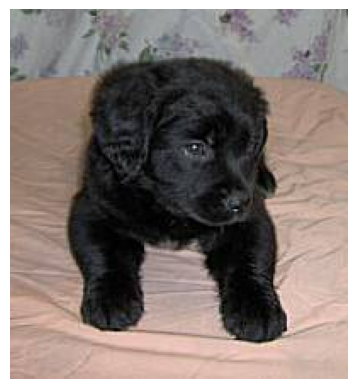

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import random
def show_image(img):
  plt.imshow(img)
  plt.axis('off')
  plt.show()

show_image(Image.open(image_paths[1]))

In [7]:
img=Image.open(image_paths[0])
print(img.size)

(199, 172)


In [8]:
class conf:
  batch_size=32
  lr=0.01
  img_size=img.size[0]
  temperature=1

In [9]:
from torchvision import transforms as tr
s=1
ssl_transform=tr.Compose(
    [
        tr.RandomResizedCrop(size=conf.img_size),
        tr.RandomHorizontalFlip(p=0.5),
        tr.RandomApply([tr.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)],p=0.8),
        tr.RandomApply([tr.GaussianBlur((3,3),(0.1,2.0))]),
        tr.RandomGrayscale(p=0.2),
        tr.ToTensor(),
        tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [10]:
from torch.utils.data import Dataset

class shape_dataset(Dataset):
  def __init__(self,image_paths,transforms=None):
    super().__init__()
    self.image_paths=image_paths
    self.transforms=transforms

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self,index):
    img=Image.open(self.image_paths[index])
    img=self.transforms(img) if self.transforms else img
    return img


dataset=shape_dataset(image_paths,ssl_transform)
len(dataset)

25000

In [11]:
from torch.utils.data import DataLoader
dataloader1=DataLoader(dataset,batch_size=conf.batch_size,shuffle=True)
dataloader2=DataLoader(dataset,batch_size=conf.batch_size,shuffle=True)
dataloader=iter(zip(dataloader1,dataloader2))
dataloader

In [12]:
len(next(iter(dataloader)))

2

In [13]:
try:
  import torchinfo
except:
  !pip install torchinfo

In [12]:
import torch
from torch import nn
from torchinfo import summary

device='cuda' if torch.cuda.is_available() else 'cpu'

class Encoder(nn.Module):
    def __init__(self, pad=1, s=2, ks=4, in_channels=3, img_size=128):
        super().__init__()

        channel = 32

        self.flayer = (nn.Sequential(
            nn.Conv2d(in_channels, channel, ks, s, pad),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU(),

            nn.Conv2d(channel, channel * 2, ks, s, pad),
            nn.BatchNorm2d(channel * 2),
            nn.LeakyReLU(),

            nn.Conv2d(channel * 2, channel * 4, ks, s, pad),
            nn.BatchNorm2d(channel * 4),
            nn.LeakyReLU(),

            nn.Conv2d(channel * 4, channel * 8, ks, s, pad),
            nn.BatchNorm2d(channel * 8),
            nn.LeakyReLU(),

            nn.Conv2d(channel * 8, channel * 16, ks, s, pad),
            nn.BatchNorm2d(channel * 16),
            nn.LeakyReLU(),

            nn.Conv2d(channel * 16, channel * 32, ks, s, pad),
            nn.BatchNorm2d(channel * 32),
            nn.LeakyReLU(),



            nn.Flatten()
        )).to(device)


        with torch.no_grad():
            randinput = torch.rand(1, in_channels, img_size, img_size).to(device)
            randsize = self.flayer(randinput).shape[1]

        self.projection = nn.Sequential(
            nn.Linear(randsize, int(randsize / 2)),
            nn.BatchNorm1d(int(randsize / 2)),
            nn.ReLU(),
            nn.Linear(int(randsize / 2), int(randsize / 8))
        )

    def forward(self, x):
        x = self.flayer(x)
        x = self.projection(x)
        return x

# Ensure model and input are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Encoder(img_size=conf.img_size).to(device)

# Use torchinfo.summary to print the model summary
summary(model, input_size=(32, 3, 199, 199), device=device)


Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [32, 1152]                --
├─Sequential: 1-1                        [32, 9216]                --
│    └─Conv2d: 2-1                       [32, 32, 99, 99]          1,568
│    └─BatchNorm2d: 2-2                  [32, 32, 99, 99]          64
│    └─LeakyReLU: 2-3                    [32, 32, 99, 99]          --
│    └─Conv2d: 2-4                       [32, 64, 49, 49]          32,832
│    └─BatchNorm2d: 2-5                  [32, 64, 49, 49]          128
│    └─LeakyReLU: 2-6                    [32, 64, 49, 49]          --
│    └─Conv2d: 2-7                       [32, 128, 24, 24]         131,200
│    └─BatchNorm2d: 2-8                  [32, 128, 24, 24]         256
│    └─LeakyReLU: 2-9                    [32, 128, 24, 24]         --
│    └─Conv2d: 2-10                      [32, 256, 12, 12]         524,544
│    └─BatchNorm2d: 2-11                 [32, 256, 12, 12]        

In [36]:
import torch.nn.functional as F
mask=torch.eye(conf.batch_size*2,conf.batch_size*2).unsqueeze(0).to(device)
def criterion(z1,z2):
  batch_size=z1.shape[0]
  z1=F.normalize(z1,p=2,dim=1)
  z2=F.normalize(z2,p=2,dim=1)

  z=torch.cat((z1,z2),dim=0)
  cos=nn.CosineSimilarity(dim=2)
  sim_mat=cos(z.unsqueeze(0),z.unsqueeze(1))

  pos1=torch.diag(sim_mat,batch_size).to(device)
  pos2=torch.diag(sim_mat,-batch_size).to(device)

  pos=torch.cat((pos1,pos2),dim=0)
  nominator=torch.exp(pos/conf.temperature)
  denominator=(mask*sim_mat)*(torch.exp(sim_mat/conf.temperature))

  all_loss=-torch.log(pos/torch.sum(denominator))
  loss=torch.sum(all_loss)/(2*batch_size)

  return loss

criterion(torch.rand(32,3).to(device),torch.rand(32,3).to(device))
optimizer=torch.optim.Adam(model.parameters(),lr=conf.lr)

In [ ]:
from tqdm import tqdm
def train(model,criterion,optimizer,dataloader,transform):
  total_loss=0
  for i,(x1,x2) in enumerate(iter(dataloader)):
    model.train()
    y1=model(x1.to(device))
    y2=model(x2.to(device))
    loss=criterion(y1,y2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss


    print(f"loss for iter {i} is {loss}")



  return total_loss/(2*len(x1))


total_loss=[]
for i in tqdm(range(10)):
  loss=train(model,criterion,optimizer,dataloader,ssl_transform)
  total_loss.append(loss)
  print(loss)



  0%|          | 0/10 [00:00<?, ?it/s]

loss for iter 0 is 5.1589274406433105
loss for iter 1 is 5.158903121948242
loss for iter 2 is 5.158918380737305
loss for iter 3 is 5.1589202880859375
loss for iter 4 is 5.158947944641113
loss for iter 5 is 5.158926010131836
loss for iter 6 is 5.158921718597412
loss for iter 7 is 5.158916473388672
loss for iter 8 is 5.158903121948242
loss for iter 9 is 5.158910751342773
loss for iter 10 is 5.158918380737305
loss for iter 11 is 5.158902645111084
loss for iter 12 is 5.158914089202881
loss for iter 13 is 5.158907890319824
loss for iter 14 is 5.1589226722717285
loss for iter 15 is 5.158902168273926
loss for iter 16 is 5.1589179039001465
loss for iter 17 is 5.158905506134033
loss for iter 18 is 5.158912658691406
loss for iter 19 is 5.1589155197143555
loss for iter 20 is 5.158901214599609
loss for iter 21 is 5.158904552459717
loss for iter 22 is 5.158910751342773
loss for iter 23 is 5.158899307250977
loss for iter 24 is 5.158907413482666
loss for iter 25 is 5.158903121948242
loss for iter 26 

In [28]:
torch.cat((torch.rand(32,128,128,3),torch.rand(32,128,128,3)),dim=0).shape

torch.Size([64, 128, 128, 3])